In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "hbase"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 25
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,hbase,0,1,0.839161,0.368098,0.511727,0.783025,0.587759,0.787211,0.938503,base
1,hbase,0,2,1.000000,0.350202,0.518741,0.854924,0.591779,0.939116,1.000000,base
2,hbase,0,3,0.842466,0.310606,0.453875,0.780947,0.535823,0.812080,0.924342,base
3,hbase,0,4,0.853081,0.407240,0.551302,0.790834,0.598588,0.836505,0.879845,base
4,hbase,0,5,0.827815,0.299760,0.440141,0.730195,0.521747,0.804887,0.908127,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,hbase,15,16,0.600000,0.732558,0.659686,0.716799,0.680197,0.646646,0.631579,ecoselekt
1,hbase,15,17,0.553719,0.779070,0.647343,0.718278,0.640341,0.606097,0.526316,ecoselekt
2,hbase,15,18,0.548673,0.911765,0.685083,0.829267,0.747992,0.650409,0.613636,ecoselekt
3,hbase,15,19,0.472441,0.882353,0.615385,0.761364,0.659160,0.586347,0.492424,ecoselekt
4,hbase,15,20,0.516949,0.824324,0.635417,0.711283,0.671875,0.497389,0.547619,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,hbase,15,16,0.600000,0.732558,0.659686,0.716799,0.680197,0.646646,0.631579,best
1,hbase,15,17,0.553719,0.779070,0.647343,0.718278,0.640341,0.606097,0.526316,best
2,hbase,15,18,0.548673,0.911765,0.685083,0.829267,0.747992,0.650409,0.613636,best
3,hbase,15,19,0.472441,0.882353,0.615385,0.761364,0.659160,0.586347,0.492424,best
4,hbase,15,20,0.516949,0.824324,0.635417,0.711283,0.671875,0.497389,0.547619,best


(110, 11)


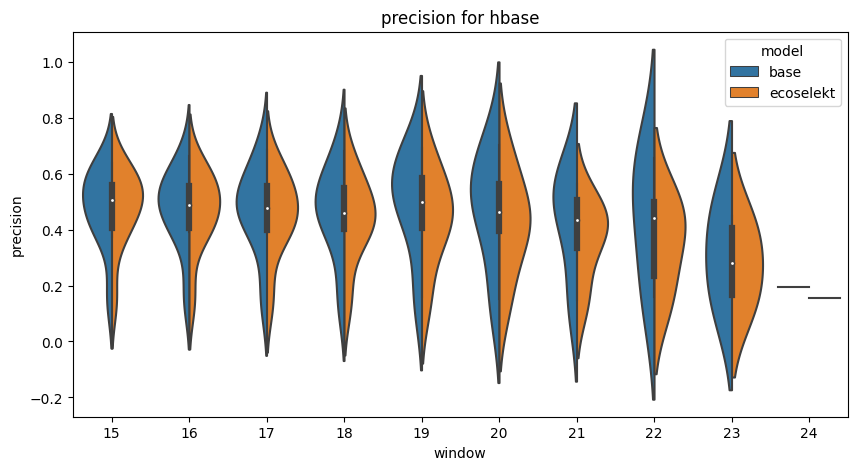

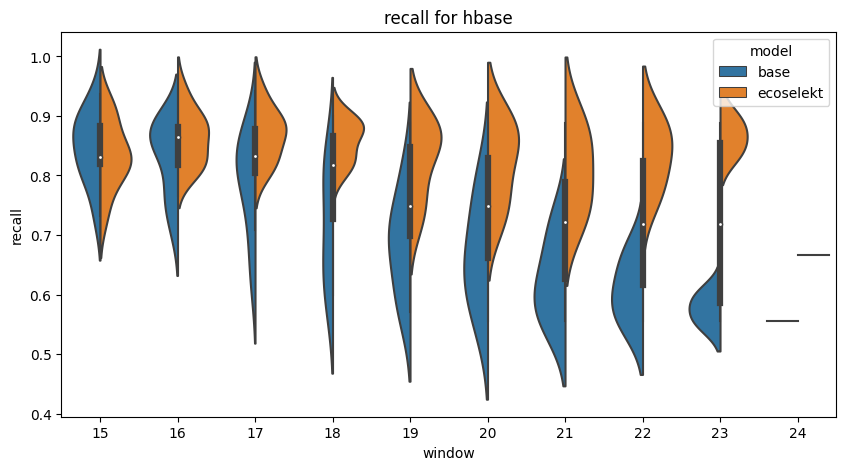

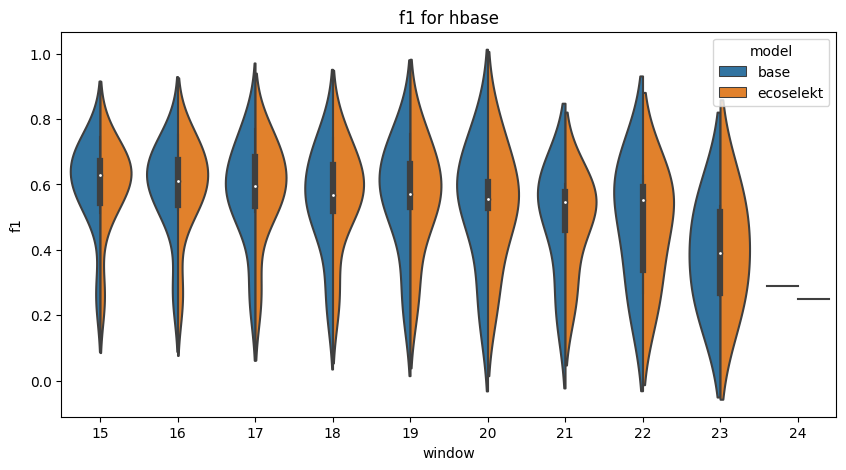

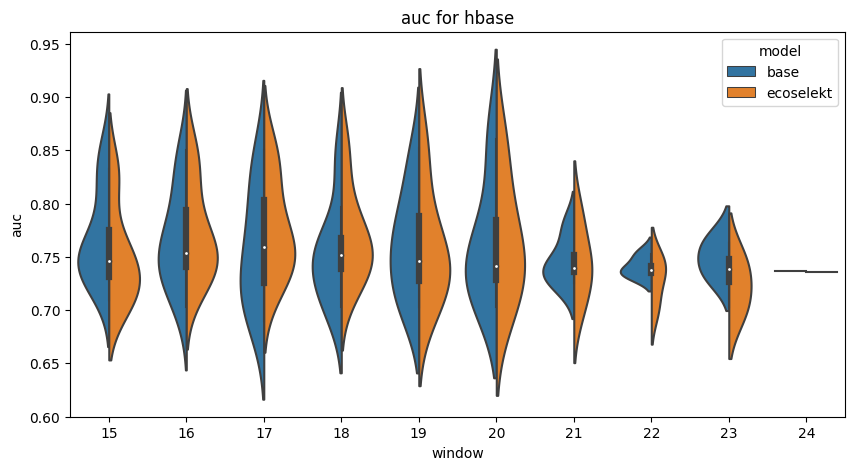

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


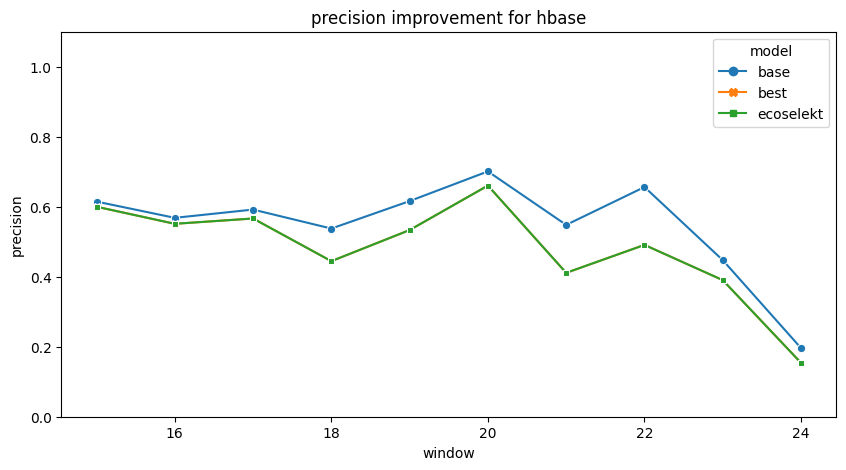

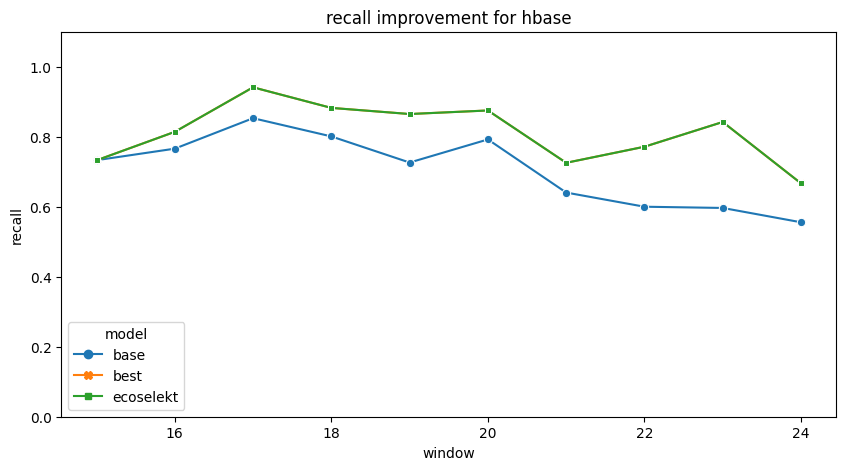

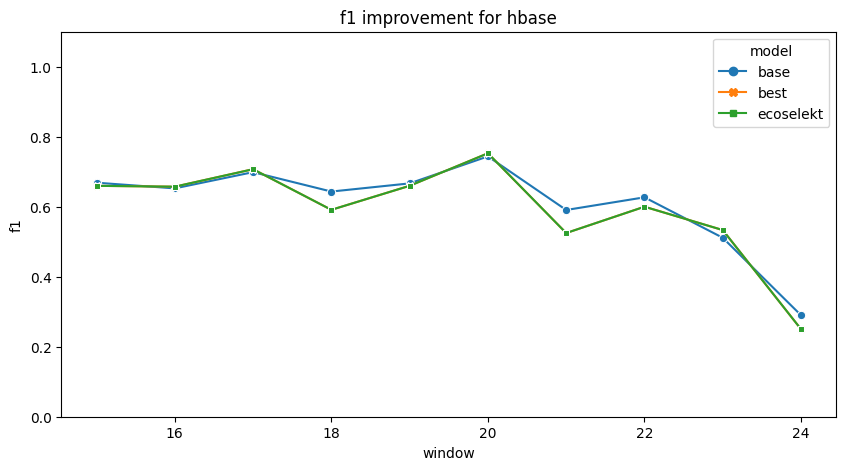

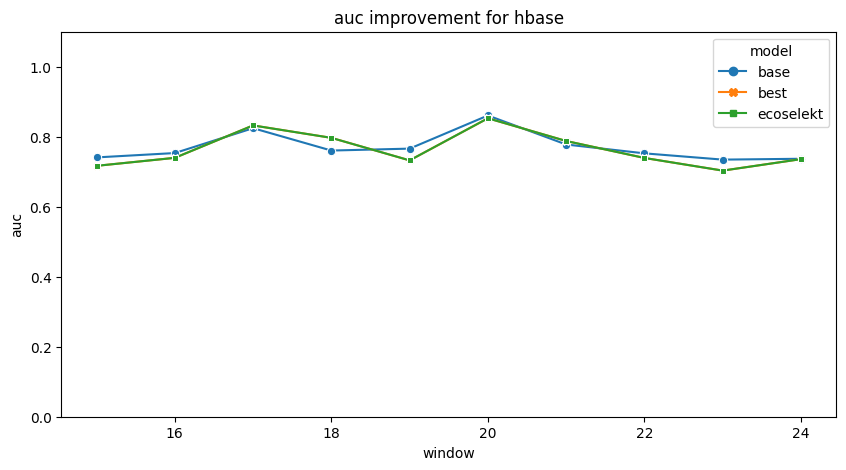

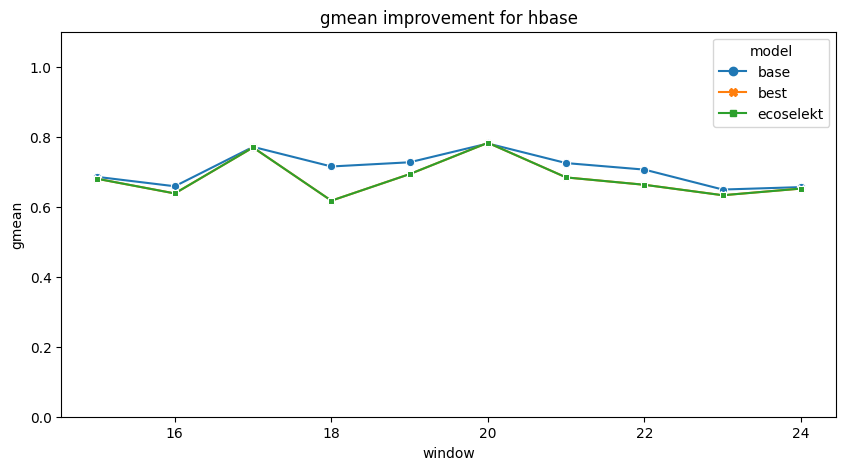

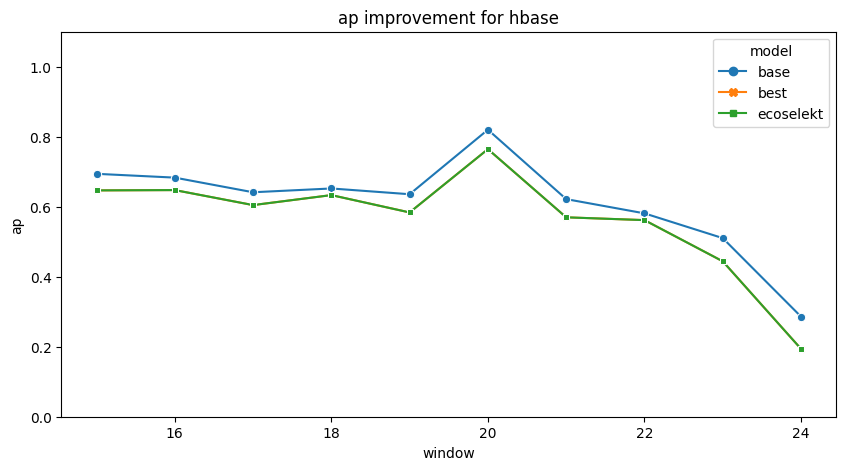

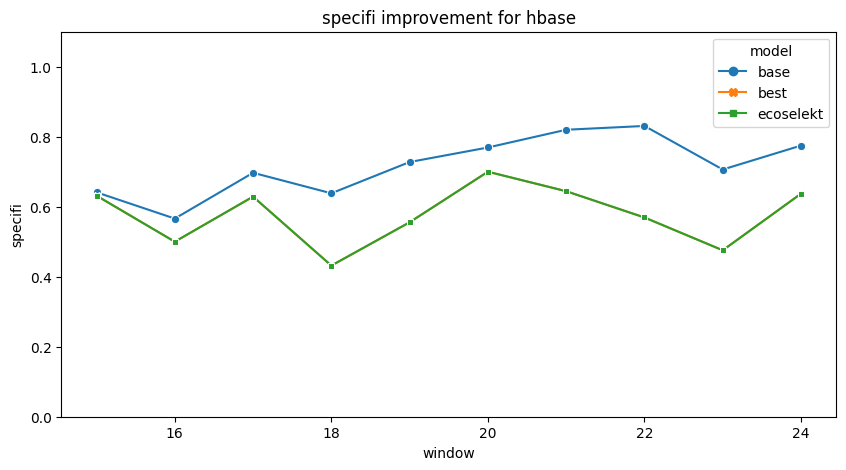

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

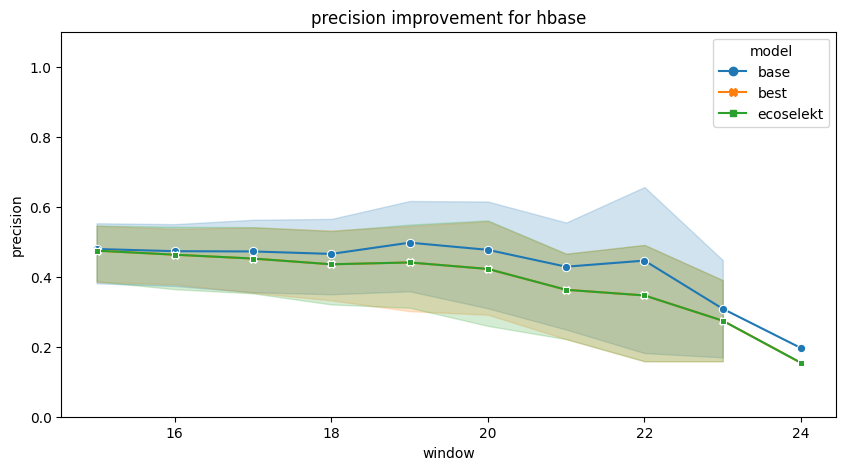

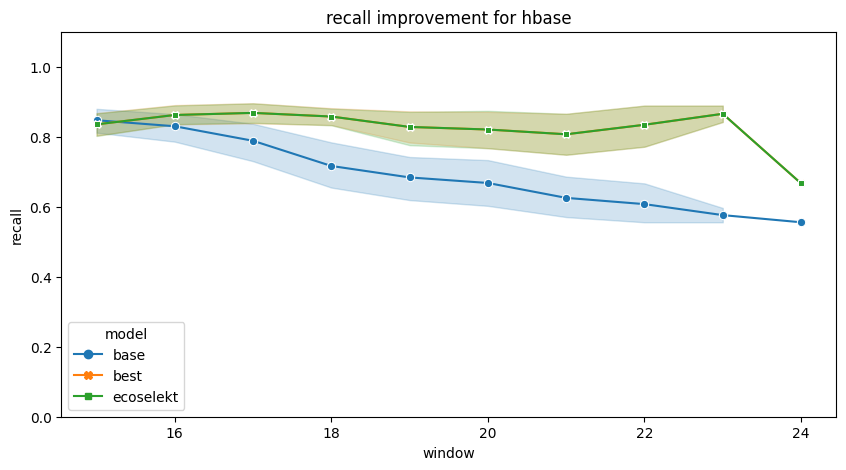

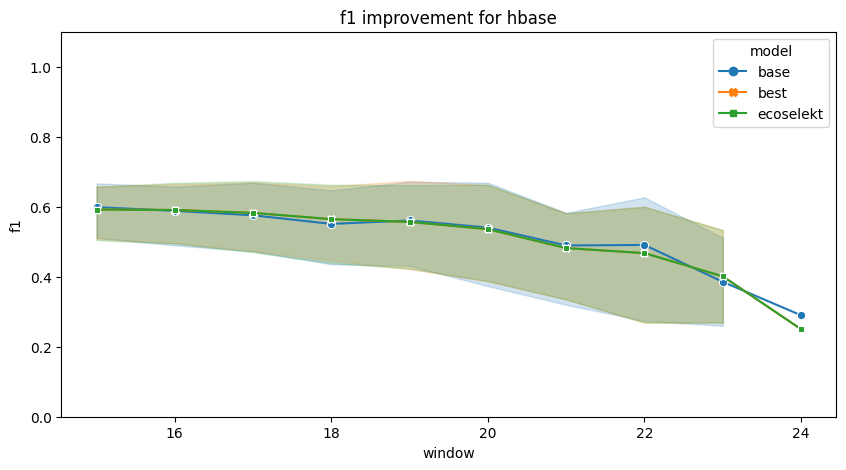

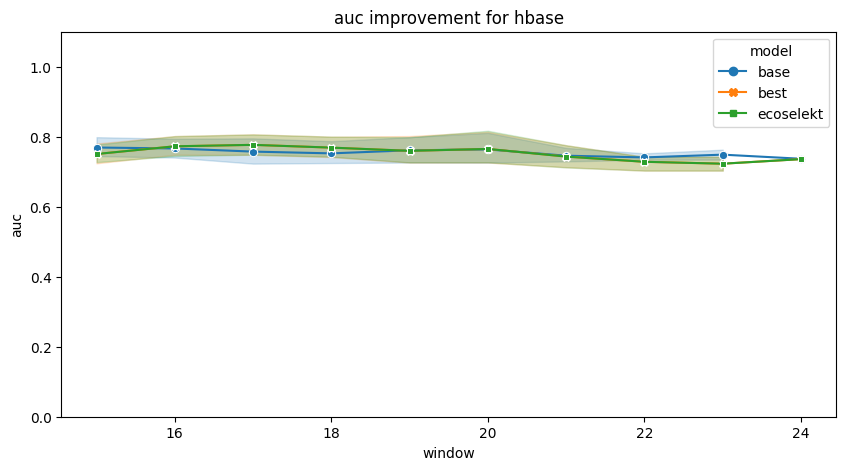

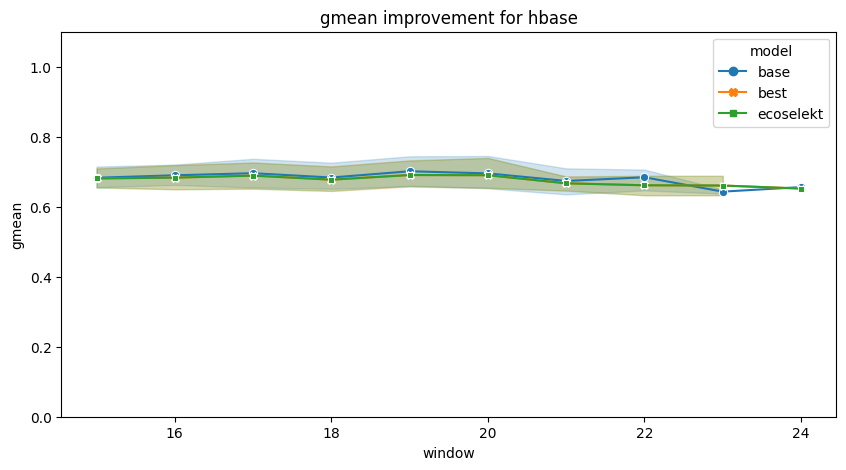

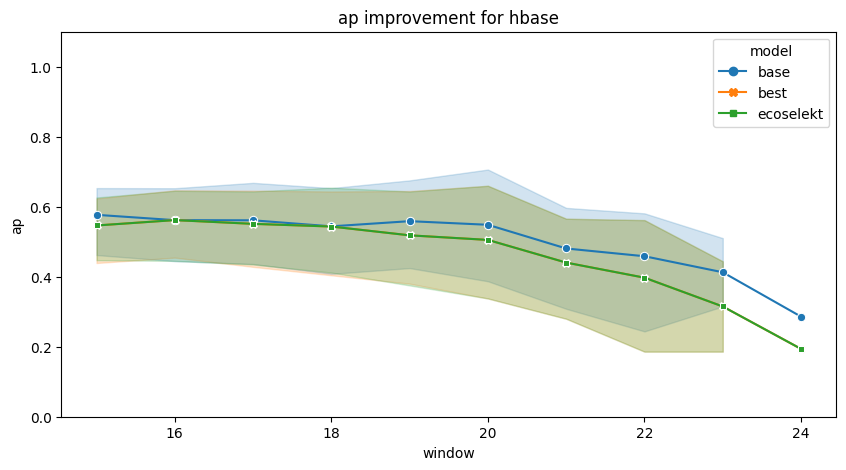

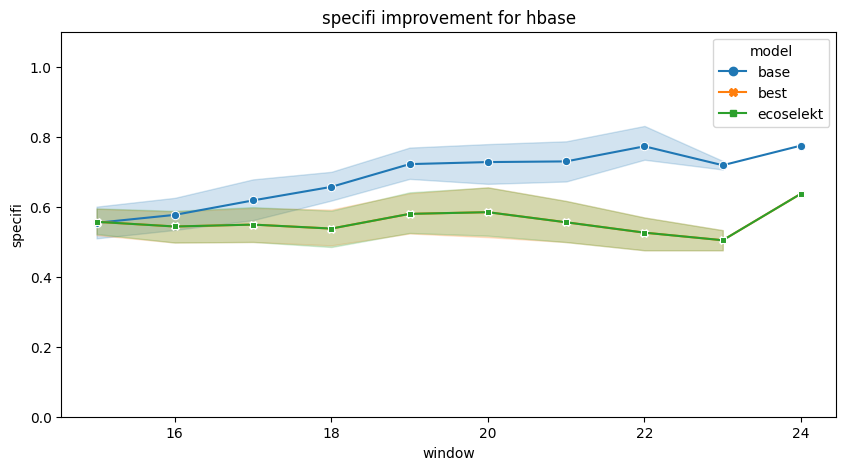

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.275390625
Wilcoxon test significance: False


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.00390625
Wilcoxon test significance: True


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(11000, 4)


,commit_id,window,test_split,model_version
0,d78eddfdc8bad5068600e28a039276cc55063ce2,15,16,2
1,546ac1cbb379acb198b2debabbf14c878ffb8a33,15,16,2
2,1822bb5d9578e3e650115a220132ab85e7db732a,15,16,2
3,e04e7402cd5df5fc7001101ad50fc2dbf8de5c1e,15,16,2
4,93e200d52b29d35ad5a98eed9eea05783960f6b2,15,16,2


In [12]:
selektmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selected_model_per_test_split.csv")
selektmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(selektmodel_df.shape)
selektmodel_df.head()

(55200, 4)


,commit_id,window,test_split,model_version
0,0277f566162f289b1b5c3bab0e34cabf5c8c566c,15,16,15
1,063243c88012241dc24fbcc39de349f49302d79e,15,16,8
2,08bd55aab2c12b136e2b75941f0c4819bab2acef,15,16,15
3,0b0825ad8ef33064e419e6293731a8ce3331894c,15,16,11
4,0b737248c3857966a57cf0af14bd9cf81e9292f7,15,16,15


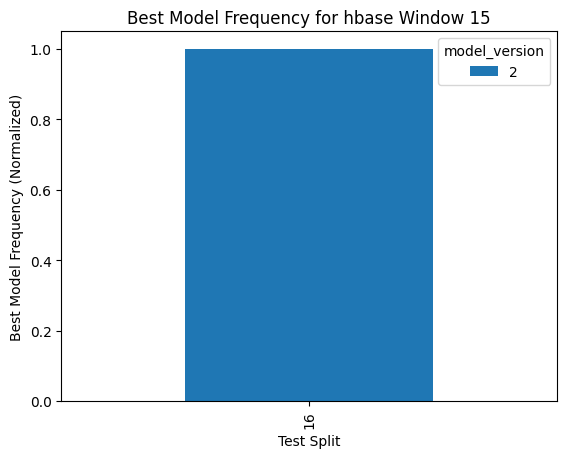

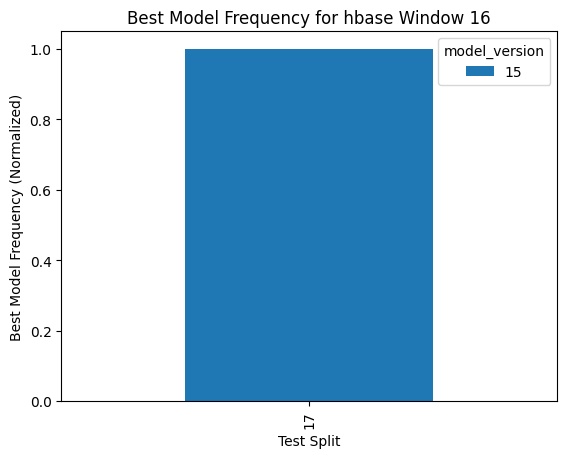

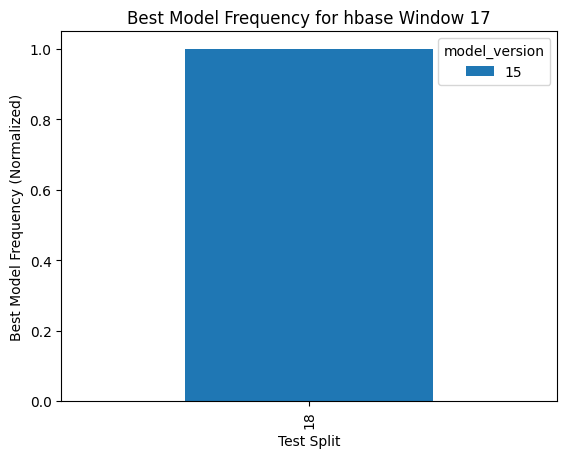

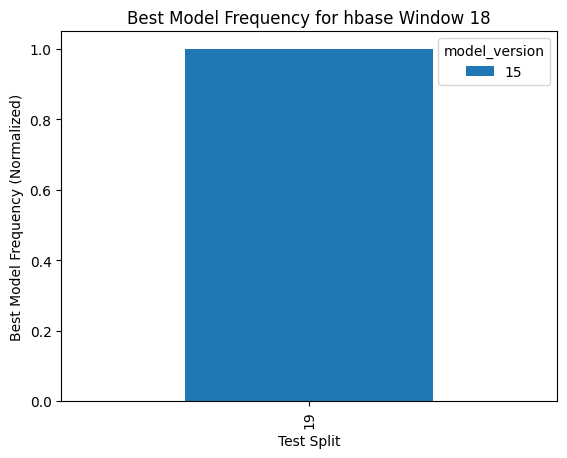

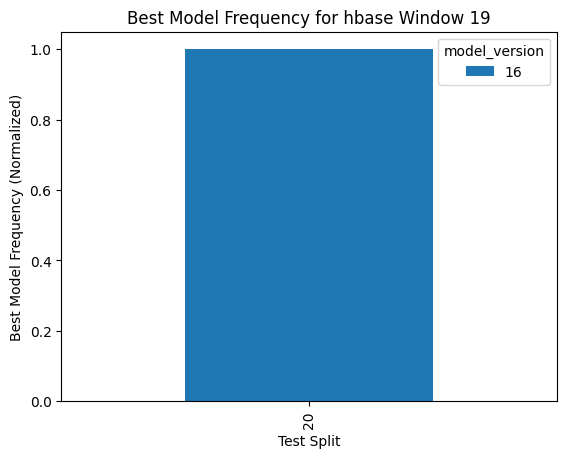

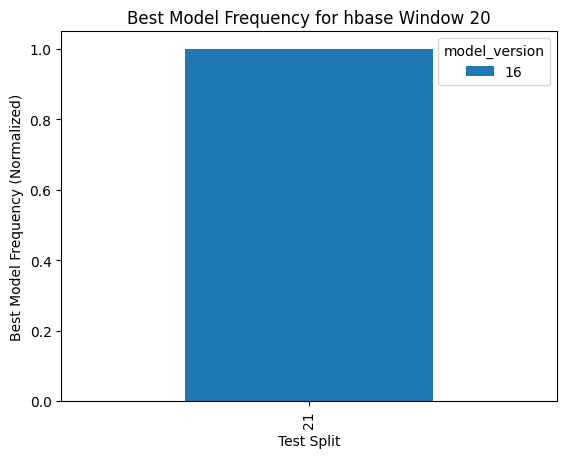

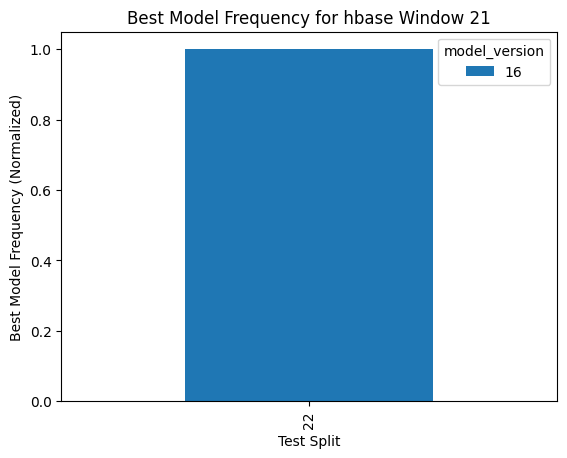

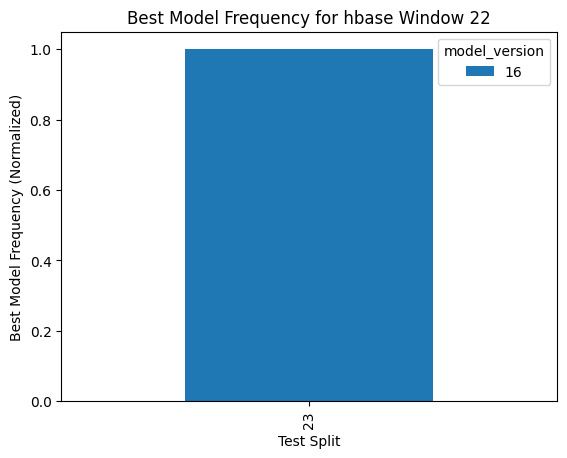

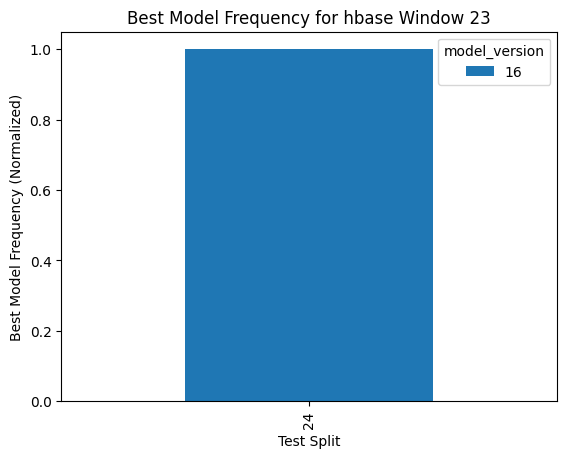

In [13]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")